**Importing Necessary Libraries**


In [22]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
import h5py

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint


from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

 


**Mounting Google Drive to read Model weights and Data**

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!ls '/content/drive/My Drive/Age_Prediction'


adience_1.h5		girl.jpg	vgg_face_weights.h5
Collab_AgeGender.ipynb	kurt_angle.jpg


**Defining the Model**

In [25]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(227,227, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [26]:
# Checking out the model 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_39 (ZeroPaddi (None, 229, 229, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 227, 227, 64)      1792      
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 229, 229, 64)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 227, 227, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 113, 113, 64)      0         
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 115, 115, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 113, 113, 128)    

**Loading pretrained VGG model weights from the directory**

In [27]:
model.load_weights('/content/drive/My Drive/Age_Prediction/vgg_face_weights.h5')

In [28]:
classes = 2 #man woman
print("number of output classes: ",classes)

number of output classes:  2


In [34]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

gender_model = Model(inputs=model.input, outputs=base_model_output)

In [35]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

gender_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

**Reading training data from H5 serialized object and creating a train test split**

In [31]:

dataset_file="/content/drive/My Drive/Age_Prediction/adience_1.h5"
folder_to_test=1
with h5py.File(dataset_file, 'r') as hf:
        print(hf.keys())
        
        print(len(hf['y_test_gender'].value))
        print(len(hf['y_train_gender'].value))
        print(len(hf['x_test'].value))
        print(len(hf['x_train'].value))
        #break
        train_x = np.array(hf.get("x_train"), dtype=np.float32)
        test_x = np.array(hf.get("x_test"), dtype=np.float32)
        train_y = np.array(hf.get("y_train_gender"), dtype=np.uint8)
        test_y = np.array(hf.get("y_test_gender"), dtype=np.uint8)
        
        
#         train_x = hf['x_train'].value.astype(np.uint8)
#         test_x = hf['x_test'].value.astype(np.uint8)
#         train_y = hf['y_train_gender'].value.astype(np.uint8)
#         test_y = hf['y_test_gender'].value.astype(np.uint8)
        


<KeysViewHDF5 ['x_test', 'x_train', 'y_test_gender', 'y_train_gender']>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


226
4288
226
4288


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.


In [32]:
# one hot encode catagorical target labels  
train_y1 = keras.utils.to_categorical(train_y, classes)
test_y = keras.utils.to_categorical(test_y, classes)
train_y1

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Train the model and save it's weights as checkpoints**

In [36]:
#checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Age_Prediction/FinalCheckpoint{epoch:08d}.h5', period=50) 
#model.fit(X_train, Y_train, callbacks=[checkpoint])
#callbacks=[checkpoint]

final_model=gender_model.fit(
            train_x, train_y1
            , epochs= 100
            , validation_data=(test_x, test_y)
            , batch_size = 64
            
        )


Epoch 1/100
67/67 [==============================] - 30s 450ms/step - loss: 66.0153 - accuracy: 0.7969 - val_loss: 0.7340 - val_accuracy: 0.8451
Epoch 2/100
67/67 [==============================] - 30s 452ms/step - loss: 0.9017 - accuracy: 0.8934 - val_loss: 0.7694 - val_accuracy: 0.8717
Epoch 3/100
67/67 [==============================] - 30s 446ms/step - loss: 0.7744 - accuracy: 0.9114 - val_loss: 0.7280 - val_accuracy: 0.8982
Epoch 4/100
67/67 [==============================] - 30s 448ms/step - loss: 0.6400 - accuracy: 0.9268 - val_loss: 0.6042 - val_accuracy: 0.8717
Epoch 5/100
67/67 [==============================] - 30s 447ms/step - loss: 0.5522 - accuracy: 0.9282 - val_loss: 0.9318 - val_accuracy: 0.8982
Epoch 6/100
67/67 [==============================] - 30s 447ms/step - loss: 0.5811 - accuracy: 0.9347 - val_loss: 0.6815 - val_accuracy: 0.8894
Epoch 7/100
67/67 [==============================] - 30s 448ms/step - loss: 0.5552 - accuracy: 0.9368 - val_loss: 0.9523 - val_accuracy

In [38]:
# Saving the Final Model weights  
gender_model.save_weights('/content/drive/My Drive/Age_Prediction/Final_Model.h5')

In [40]:
#Saving final model architecture and weights in one file
gender_model.save('/content/drive/My Drive/Age_Prediction/VGG_Architecture.h5')

**Model Evaluation**

In [41]:
loss,acc = gender_model.evaluate(test_x, test_y, verbose = 2, batch_size = 64)
print("Validation Loss: %.2f" % (loss))
print("Validation Accuracy: %.2f" % (acc))

4/4 - 1s - loss: 8.0243 - accuracy: 0.9292
Validation Loss: 8.02
Validation Accuracy: 0.93


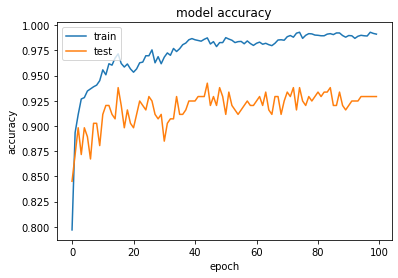

In [42]:
# plotting accuracy vs epochs 
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(final_model.history['accuracy'])
plt.plot(final_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

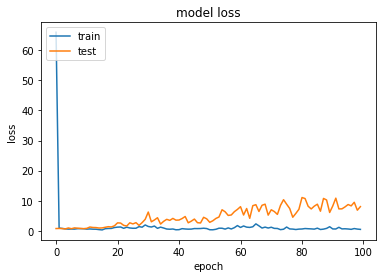

In [43]:
#Plotting loss vs epochs 
plt.plot(final_model.history['loss'])
plt.plot(final_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Inference**

We have obtained a validation accuracy of 93 percent and validation loss of 8.02. For 100 epochs we can observe that the loss and accuracy for both training and validation are following similar trends. The difference between the training and validation results is also not very significant for the model to be overfitting. In future, we can try to improve the model performance by changing the network hyperparameters, training for more epochs, using more data, and using data augumentation techniques.